# Simple Demo: Step Function
This example is taken (with a bit of adaption) from [here](https://github.com/ICL-SML/Doubly-Stochastic-DGP/blob/master/demos/demo_1D_regression.ipynb). The example illustrate a deepGP fit for a step function. Normal GPs with stationary kernels usually fail at this task. We start with some imports.

In [1]:
# useful imports
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# dgplib imports
from dgplib.layers import Layer
from dgplib.cascade import Sequential
from dgplib.utilities import print_summary

from dgplib import DSDGP

In [3]:
# gpflow imports
import gpflow

from gpflow.kernels import RBF, White, Matern52
from gpflow.likelihoods import Gaussian
from gpflow.mean_functions import Linear
from gpflow.utilities import set_trainable

gpflow.config.set_summary_fmt("notebook")
gpflow.config.set_default_float(np.float64)

## Data
We start of by generating the training and test data:

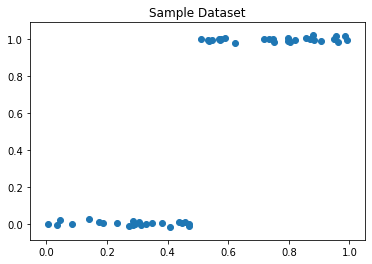

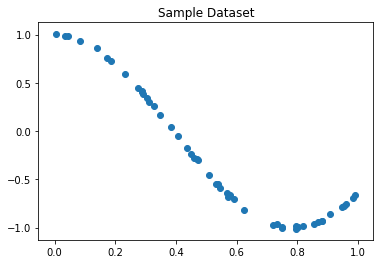

In [4]:
Ns = 300
Xs = np.linspace(-0.5, 1.5, Ns)[:, None]

N, M = 50, 25
X = np.random.uniform(0, 1, N)[:, None]
Z = np.random.uniform(0, 1, M)[:, None]
f_step = lambda x: 0. if x<0.5 else 1.
Y1 = np.reshape([f_step(x) for x in X], X.shape) + np.random.randn(*X.shape)*1e-2
Y2 = np.reshape([np.cos(4*x) for x in X], X.shape) + np.random.randn(*X.shape)*1e-2
Y = np.hstack([Y1, Y2])

def plot_data(X, Y):
    plt.title('Sample Dataset')
    plt.scatter(X, Y)
    plt.show()
    
plot_data(X, Y1)
plot_data(X, Y2)

## Model Construction
We move on to constructing the model. First we initialize the layers. In this example we are using a 2-layer DGP, an input layer and an output layer.

In [5]:
# Layers
def make_input_layer_kernels():
    kernel = gpflow.kernels.mo_kernels.SeparateIndependentMok(
        [RBF(variance=0.2, lengthscale=1.0) + White(variance=1e-5),
         RBF(variance=1.1, lengthscale=0.23) + White(variance=1e-5)]
    )
    return kernel

def make_output_layer_kernel(lengthscale, variance):
    kernel = gpflow.kernels.mo_kernels.SharedIndependentMok(
        RBF(variance=variance, lengthscale=lengthscale) + White(variance=1e-5),
        output_dimensionality=2
    )
    return kernel


input_layer = Layer(
    input_dim=1,
    output_dim=2, 
    kernel=make_input_layer_kernels(),
    num_inducing=M,
    fixed_linear_mean_function=True
)

input_layer.q_sqrt.assign(input_layer.q_sqrt * 1e-5)

output_layer = Layer(
    input_dim=2, 
    output_dim=2,
    kernel=make_output_layer_kernel(lengthscale=0.2, variance=1.),
    num_inducing=M
)

Next, we wrap the layers around a `Sequential` object. This takes care of initializing the inducing inputs when fed into the model.

In [6]:
seq = Sequential([input_layer, output_layer])

Finally, we create and compile a model object.

In [7]:
model = DSDGP(Z=Z, layers=seq, likelihood=Gaussian(), num_latent=2)

In [8]:
print_summary(model)

name,class,transform,trainable,shape,dtype,value
DSDGP.likelihood.variance,Parameter,Softplus,True,(),float64,1.0
DSDGP.layers.constituents[0].kernel.kernels[0].kernels[0].variance,Parameter,Softplus,True,(),float64,0.20000000298023218
DSDGP.layers.constituents[0].kernel.kernels[0].kernels[0].lengthscale,Parameter,Softplus,True,(),float64,1.0
DSDGP.layers.constituents[0].kernel.kernels[0].kernels[1].variance,Parameter,Softplus,True,(),float64,9.999999747440792e-06
DSDGP.layers.constituents[0].kernel.kernels[1].kernels[0].variance,Parameter,Softplus,True,(),float64,1.100000023841858
DSDGP.layers.constituents[0].kernel.kernels[1].kernels[0].lengthscale,Parameter,Softplus,True,(),float64,0.23000000417232516
DSDGP.layers.constituents[0].kernel.kernels[1].kernels[1].variance,Parameter,Softplus,True,(),float64,9.999999747440792e-06
DSDGP.layers.constituents[0].mean_function.A,Parameter,,True,"(1, 1)",float64,[[1.]]
DSDGP.layers.constituents[0].mean_function.b,Parameter,,True,"(1,)",float64,[0.]
DSDGP.layers.constituents[0].q_mu,Parameter,,True,"(25, 2)",float64,"[[0., 0...."


In [9]:
model.initialize_layers_from_data(X)

Model Parameters Initialized


In [10]:
print_summary(model)

name,class,transform,trainable,shape,dtype,value
DSDGP.likelihood.variance,Parameter,Softplus,True,(),float64,1.0
DSDGP.layers.constituents[0].feature.features[0].Z,Parameter,,True,"(25, 1)",float64,[[0.05908349...
DSDGP.layers.constituents[0].feature.features[1].Z,Parameter,,True,"(25, 1)",float64,[[0.05908349...
DSDGP.layers.constituents[0].kernel.kernels[0].kernels[0].variance,Parameter,Softplus,True,(),float64,0.20000000298023218
DSDGP.layers.constituents[0].kernel.kernels[0].kernels[0].lengthscale,Parameter,Softplus,True,(),float64,1.0
DSDGP.layers.constituents[0].kernel.kernels[0].kernels[1].variance,Parameter,Softplus,True,(),float64,9.999999747440792e-06
DSDGP.layers.constituents[0].kernel.kernels[1].kernels[0].variance,Parameter,Softplus,True,(),float64,1.100000023841858
DSDGP.layers.constituents[0].kernel.kernels[1].kernels[0].lengthscale,Parameter,Softplus,True,(),float64,0.23000000417232516
DSDGP.layers.constituents[0].kernel.kernels[1].kernels[1].variance,Parameter,Softplus,True,(),float64,9.999999747440792e-06
DSDGP.layers.constituents[0].mean_function.A,Parameter,,False,"(1, 2)",float64,[[1. 0.]]


## Training
We train the model by maximising the variational lower bound on the log marginal likelihood. We use the Adam optimiser packaged with `GPflow` for this task.

In [11]:
model.log_likelihood(X, Y, 1)

<tf.Tensor: id=1610, shape=(), dtype=float64, numpy=-718.9586061941467>

/home/ayman/anaconda3/envs/multitask-gpflow-2.0a0/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/home/ayman/anaconda3/envs/multitask-gpflow-2.0a0/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/ayman/anaconda3/envs/multitask-gpflow-2.0a0/lib/python3.7/site-packages/ipykernel_launche

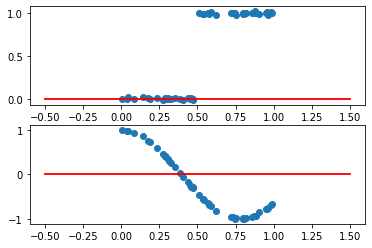

In [13]:
plt.figure()
for _ in range(10):
    mu, sigma = model.predict_f(Xs, 1)
    plt.subplot(211)
    plt.plot(Xs, mu[:,:,0].numpy().reshape(Xs.shape), color='r', alpha=0.3)
    plt.subplot(212)
    plt.plot(Xs, mu[:,:,1].numpy().reshape(Xs.shape), color='r', alpha=0.3)
    
plt.subplot(211)
plt.scatter(X, Y1);
plt.subplot(212)
plt.scatter(X, Y2);

In [14]:
def log_likelihood_callback():
    return model.neg_log_marginal_likelihood(X, Y, num_samples=1)

In [15]:
opt = tf.optimizers.Adam(learning_rate=1e-2)
gpflow.utilities.training_loop(log_likelihood_callback, opt, model.trainable_variables, maxiter=1e3)

W0806 11:50:57.157728 139951193995072 deprecation.py:323] From /home/ayman/anaconda3/envs/multitask-gpflow-2.0a0/lib/python3.7/site-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:468: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


In [16]:
model.log_likelihood(X, Y, 1)

<tf.Tensor: id=3204323, shape=(), dtype=float64, numpy=30.479321542096102>

We can see that the bound on log marginal likelihood has increased.

## Testing
We now test our model.

/home/ayman/anaconda3/envs/multitask-gpflow-2.0a0/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/home/ayman/anaconda3/envs/multitask-gpflow-2.0a0/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/ayman/anaconda3/envs/multitask-gpflow-2.0a0/lib/python3.7/site-packages/ipykernel_launche

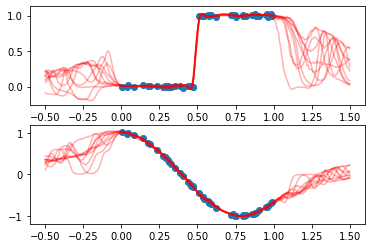

In [18]:
plt.figure()
for _ in range(10):
    mu, sigma = model.predict_f(Xs, 1)
    plt.subplot(211)
    plt.plot(Xs, mu[:,:,0].numpy().reshape(Xs.shape), color='r', alpha=0.3)
    plt.subplot(212)
    plt.plot(Xs, mu[:,:,1].numpy().reshape(Xs.shape), color='r', alpha=0.3)
    
plt.subplot(211)
plt.scatter(X, Y1);
plt.subplot(212)
plt.scatter(X, Y2);